In [82]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from datetime import datetime
import torch

In [2]:
transform = transforms.Compose(
    [      
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
) #       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet", transform=transform)

In [142]:
def plot_imgs(imgs):
    n_imgs = len(imgs)
    square_size = 8  # inches
    n_cols = math.ceil(math.sqrt(n_imgs))
    n_rows = math.ceil(n_imgs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(square_size, square_size),gridspec_kw=dict(wspace=0, hspace=0))
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    for i in range(n_imgs):
        axes[i].imshow(imgs[i])  # Replace with your image array
        axes[i].axis('off')
    
    # Hide any extra axes (if grid is larger than number of images)
    for i in range(n_imgs, len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between subplots
    plt.show()
    return fig

def get_k_imgs(dim_rid1, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    topk_indices = sorted_indices[-k:][::-1]  # descending: highest values
    print(topk_indices)
    bottomk_indices = sorted_indices[:k] 
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

def get_kk_imgs(dim_rid1, r_idx, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    topk_indices = r_idx[sorted_indices[-k:][::-1]]  # descending: highest values
    print(topk_indices)
    bottomk_indices = r_idx[sorted_indices[:k]]
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

In [4]:
model_name1 = "alexnet"
mod1_layers = get_relevant_output_layers(model_name1)

In [15]:
target_layer1 = mod1_layers[0]
pooling = "maxpool"
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)

In [16]:
dim_rid1 = feats1@PCs1.components_.T

In [17]:
k = 32
dim = 0
mod1_topk_imgs, mod1_bottomk_imgs = get_k_imgs(dim_rid1, dataset, k, dim)
path2figs = "/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs"

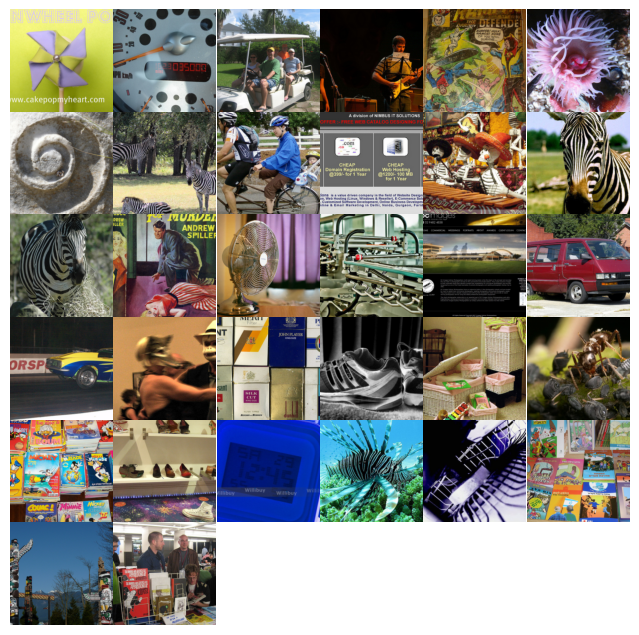

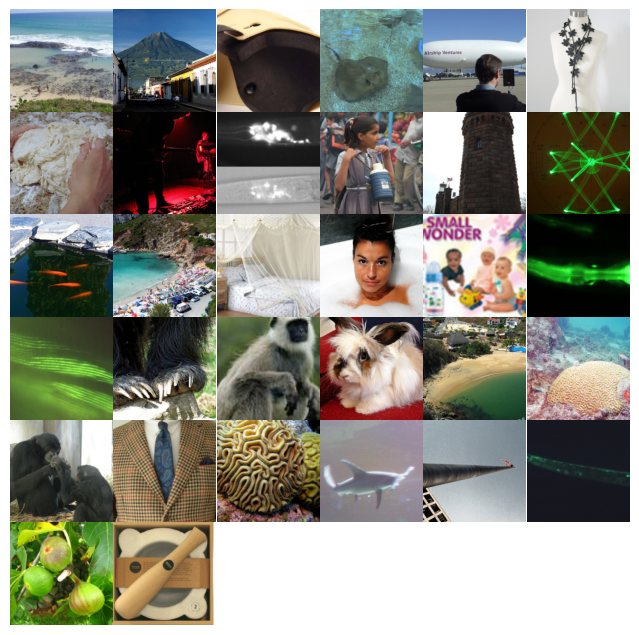

In [18]:
mod1_top = plot_imgs(mod1_topk_imgs)
mod1_bot = plot_imgs(mod1_bottomk_imgs) 
#mod1_top.savefig(f"{path2figs}/{model_name1}_pca_{target_layer1}_dim{dim}_{k}_imgs_top.png")
#mod1_bot.savefig(f"{path2figs}/{model_name1}_pca_{target_layer1}_dim{dim}_{k}_imgs_bottom.png")


In [42]:
extreme_n_imgs = 100
top_n_PCs = 10
target_layer1 = "classifier.5"
top_save_path = f"{paths["results_path"]}/{model_name1}_{target_layer1}_top_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"
bottom_save_path = f"{paths["results_path"]}/{model_name1}_{target_layer1}_bottom_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"


In [43]:
top_dims = np.loadtxt(top_save_path, delimiter=',', dtype=int)
bottom_dims = np.loadtxt(bottom_save_path, delimiter=',', dtype=int)

In [54]:
dim = 0
topk_imgs_all_feats = [dataset[i][0].permute(1,2,0) for i in top_dims[dim, :k]]
bottomk_imgs_all_feats = [dataset[i][0].permute(1,2,0) for i in bottom_dims[dim, -k:]]

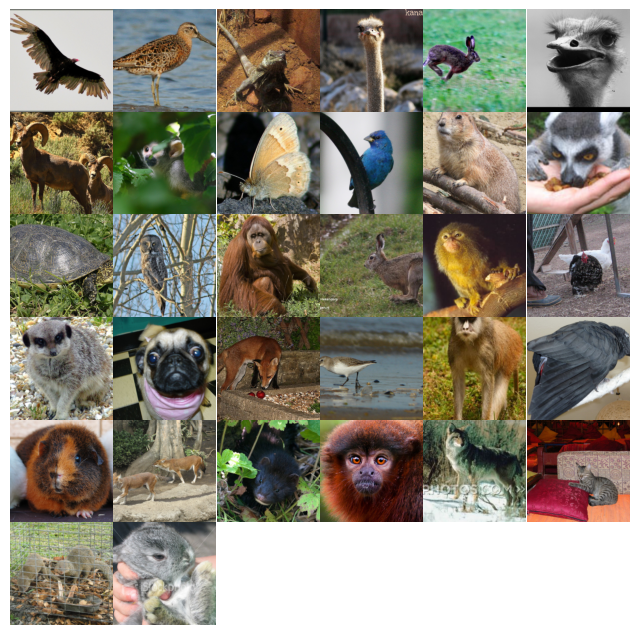

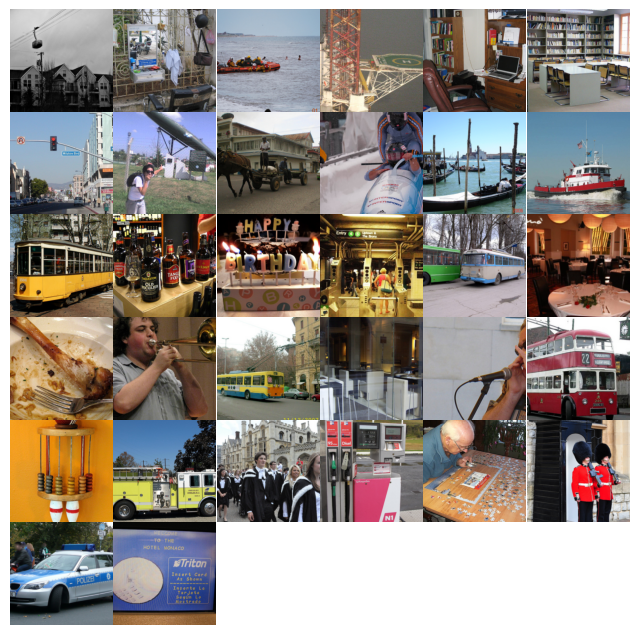

In [55]:
b = plot_imgs(topk_imgs_all_feats)
a = plot_imgs(bottomk_imgs_all_feats)

In [62]:
p = f"{paths["results_path"]}/imagenet_val_alexnet_features.0_pca_model.pkl"
f = joblib.load(p)

In [63]:
c = f.components_
print(c.shape)

(1000, 193600)


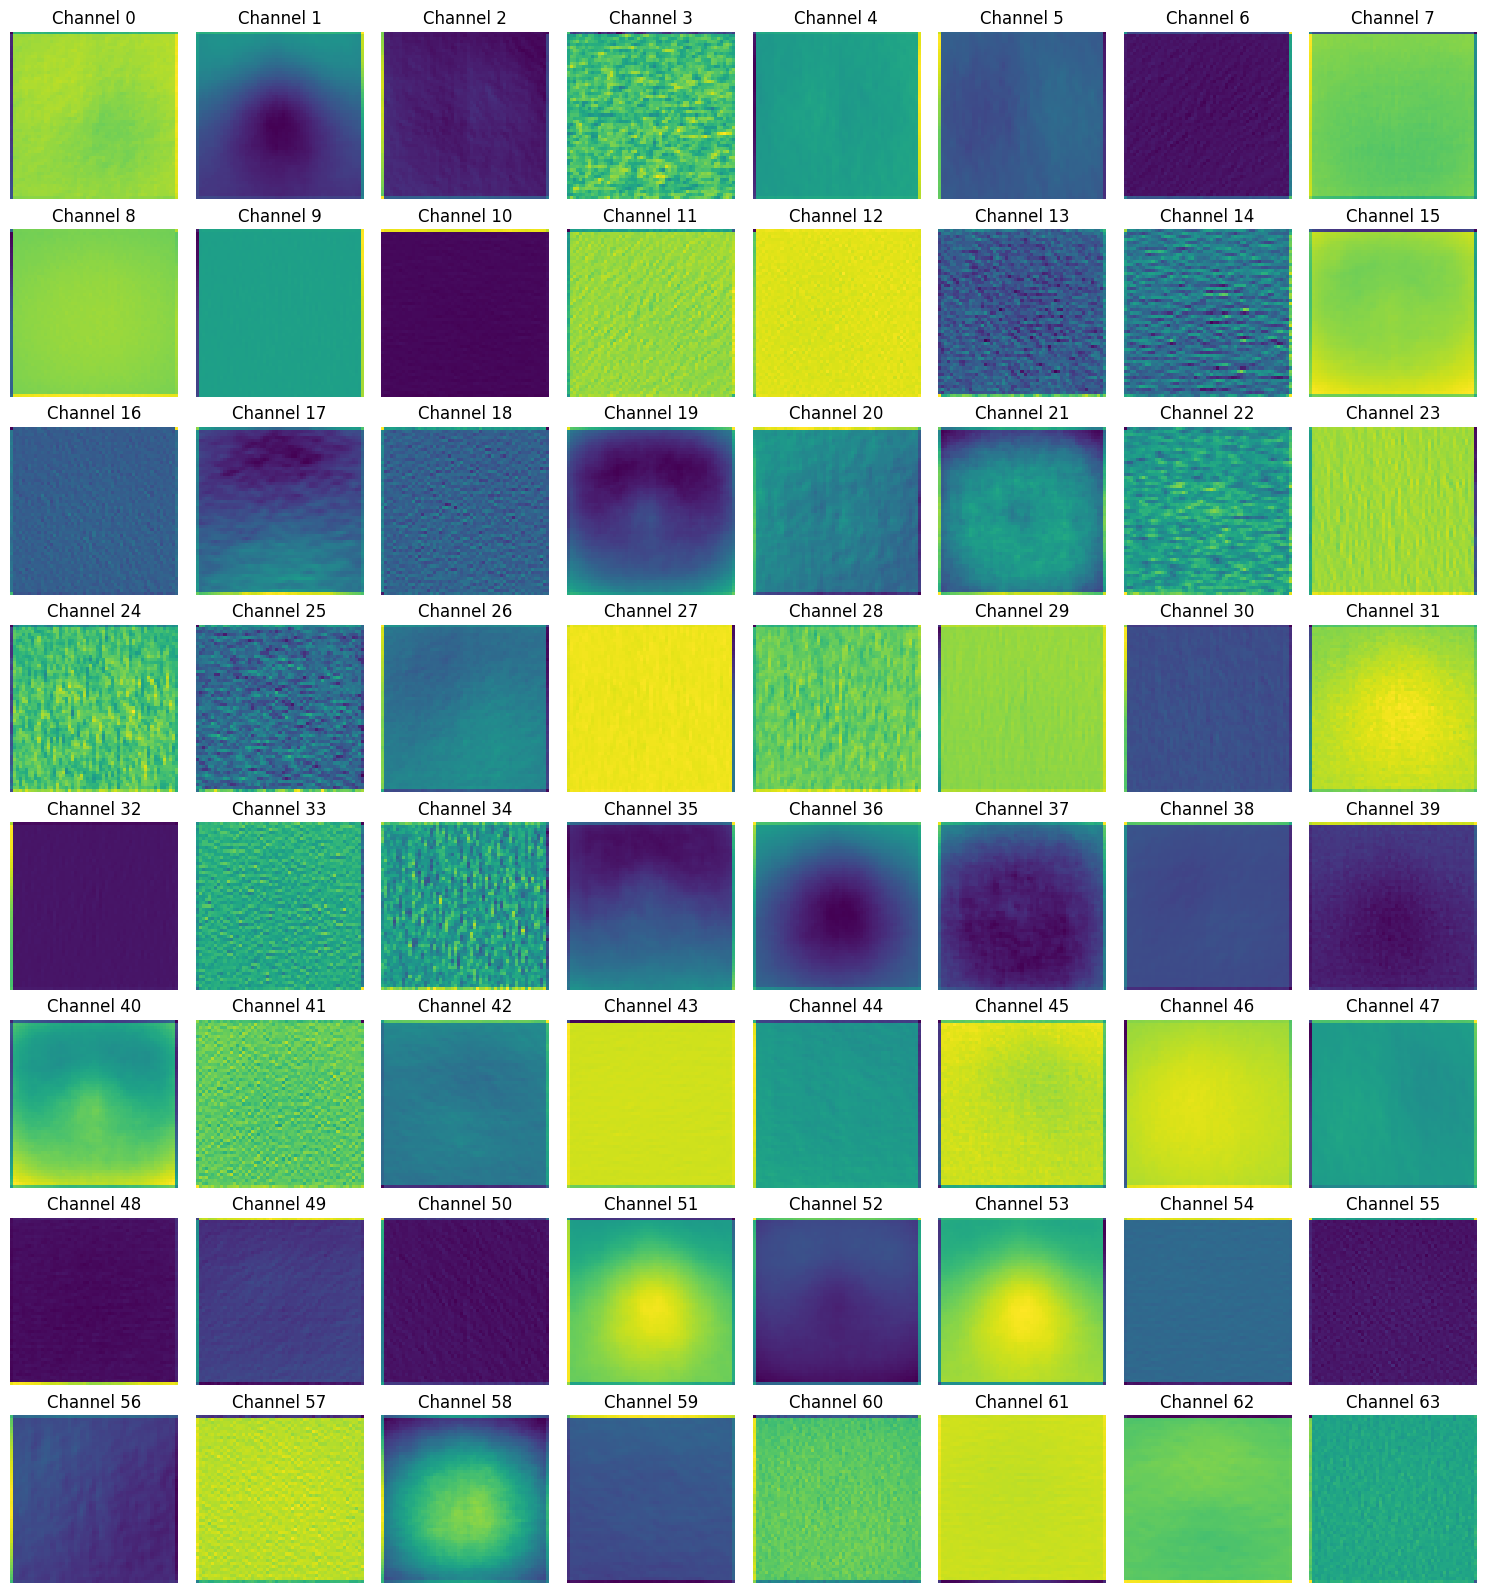

In [72]:
a = np.reshape(c[0,:], (64, 55,55))
num_channels = a.shape[0]
cols = 8
rows = int(np.ceil(num_channels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
    if i < num_channels:
        ax.imshow(a[i], cmap='viridis')
        ax.set_title(f"Channel {i}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplot

plt.tight_layout()
plt.show()

In [123]:
r_idx = np.random.choice(49000, 100, replace=False)

In [124]:
print(r_idx)

[34430 42270 45965 38122 34782  9056 19901 34854 18264  3862 47549 26299
 46018 41968 47552  8919 30174  4922 13733 19436 35099 34801 11845 38820
 12768 21824 17150 13730 14371 17279 46396  4901 30382  2808 34371 26110
 47310 37441 42488 28946 30421 38162 46727 10597 37358 10383 24592 14317
  2257  5650 45659 14129 41725  4760 35878 14066 34563 36870 45572 25455
 34340  3509  1758 12040  1147 10184 35219 29178 14496 31576 15943 10564
  3299 30998  6085  3422 32495 42690 22874 41694 33437 35690 18591 31448
 27507 48144 32739 37860 43551 22217 41013  4919 41603 42049 13316 16715
 29218  7283 16021 32353]


In [125]:
layer_name = "features.0"
model_name="alexnet"
model_cls = getattr(models, model_name)
model = model_cls(pretrained=True).to(device).eval()
feature_extractor = create_feature_extractor(
    model, return_nodes=[layer_name]
).to(device)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [126]:
counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tot_feats = []
for i in r_idx:
    inputs, _ = dataset[i]
    counter += 1
    with torch.no_grad():
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)[layer_name]
        feats = feats.view(-1).cpu().numpy()
        tot_feats.append(feats)
tot_feats = np.vstack(tot_feats)

In [127]:
dim_rid = tot_feats @ c.T

In [189]:
k = 9
dim = 0
topk, botk = get_kk_imgs(dim_rid, r_idx, dataset, k, dim)

[30998 30382 38820 47549 38122 46727 21824 10383 46396]


In [207]:
top_dims.shape

(10, 100)

In [208]:
counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tot_feats_csv = []
ord_idx = top_dims[0,:]
for i in ord_idx:
    inputs, _ = dataset[i]
    counter += 1
    with torch.no_grad():
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)[layer_name]
        feats = feats.view(-1).cpu().numpy()
        tot_feats_csv.append(feats)
tot_feats_csv = np.vstack(tot_feats)

In [213]:
aeiou = tot_feats_csv @ c.T

In [215]:
print(aeiou[:,0])

[-108.00559124  -54.49502519 -132.09179194   23.23122269  -35.91710858
  -67.65045016  -81.15174738  -90.29745977  -32.19579532  -68.76728209
   66.36785957  -37.214425    -85.27928973  -64.45668488   -0.67020302
  -51.62752037  -69.57442257   -1.87724417  -23.0339015   -74.55962317
 -116.84848127  -89.36742895  -34.73293351   68.04281857  -11.1157618
   14.32750867  -91.56602375  -15.88441207  -40.16205034 -101.99553134
    2.85771836 -164.753696    102.43255956  -96.42494036    2.76008332
    0.33384322  -81.98730406  -49.6013702   -53.60328727  -69.2531972
 -126.31106001 -100.29427689   15.09640929  -41.12532291    0.69690907
    9.72555452  -87.53299096  -89.7168869   -52.27442761  -40.97611822
 -108.69069321  -73.78041821  -42.59994074  -67.79635805  -56.81118045
  -49.94277042  -15.82422203   -9.0737439   -85.00671773  -43.36206421
  -14.86998549 -103.88996745  -71.57959825  -44.83321594  -44.4963272
  -28.34982265  -80.07577913  -76.47147017  -50.59350385 -107.59964406
  -32.046

In [212]:
#tot_feats_csv.shape
PCs1.components_.shape

(64, 64)

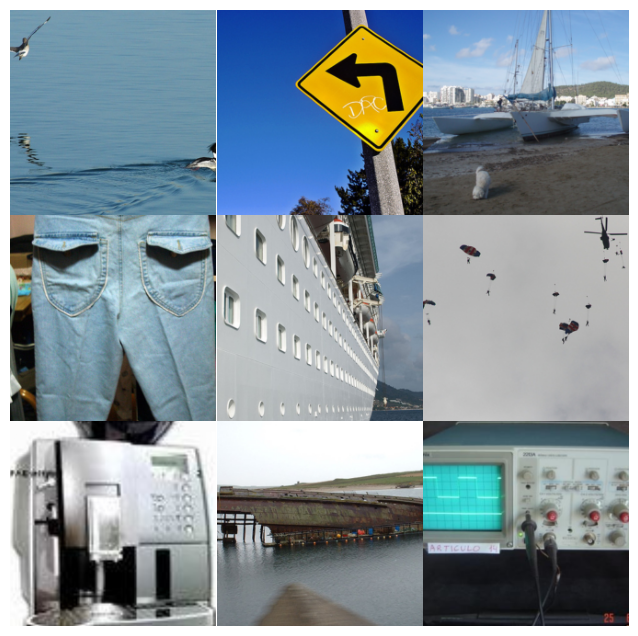

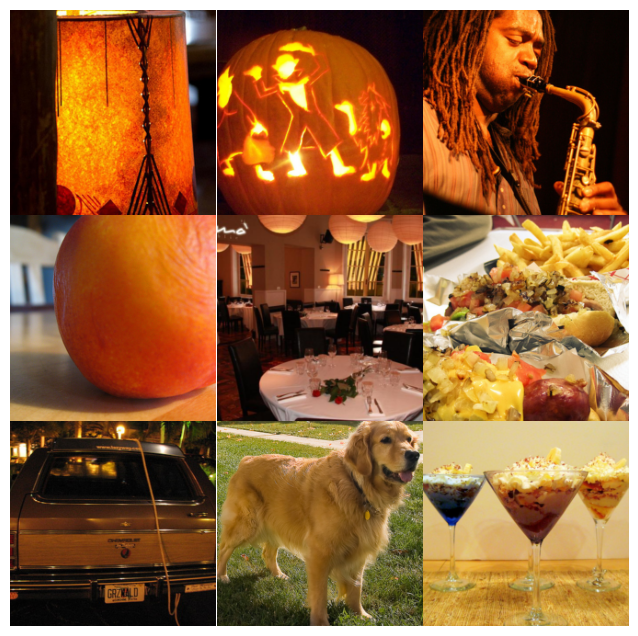

In [190]:
yy = plot_imgs(botk)
yy = plot_imgs(topk)

In [191]:
true_pcs_path = f"{paths['results_path']}/imagenet_val_alexnet_features.0_true_pca_model_1000_PCs.pkl"
PCA = joblib.load(true_pcs_path)

In [195]:
dim_redu_true = tot_feats @ PCA.components_.T

In [216]:
print(np.sort(dim_redu_true[:,0]))

[-164.75815    -132.08176    -131.50558    -126.31537    -117.08437
 -116.84774    -111.11763    -108.69074    -108.01627    -107.60186
 -103.89161    -102.00612    -100.28876     -98.5732      -96.42235
  -92.74844     -91.5655      -90.29087     -89.70532     -89.36363
  -87.53037     -85.29457     -85.00162     -82.3617      -81.98576
  -81.156975    -80.072365    -76.471825    -76.41857     -74.56806
  -74.15468     -73.78547     -73.66893     -71.578224    -69.57618
  -69.255974    -68.773155    -68.58869     -67.82443     -67.68316
  -67.212494    -65.713425    -64.44375     -62.669697    -61.780575
  -61.567745    -60.61386     -58.08876     -57.90664     -57.881523
  -56.816597    -54.493813    -53.599907    -53.21128     -52.281067
  -51.627857    -50.604626    -49.950306    -49.608166    -48.181576
  -44.841614    -44.499       -43.361626    -42.91117     -42.59842
  -42.573593    -41.12374     -40.969967    -40.146614    -37.22254
  -36.11998     -35.906918    -34.730347    

In [196]:
print(dim_redu_true.shape)

(100, 1000)


In [202]:
k = 9
dim = 2
true_topk, true_botk = get_kk_imgs(dim_redu_true, r_idx, dataset, k, dim)

[16021 26110 36870 13730 15943  3299 47552 18591  9056]


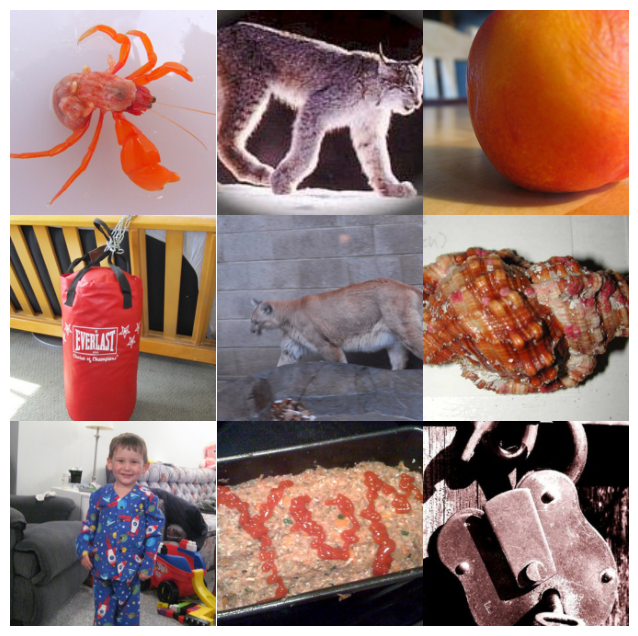

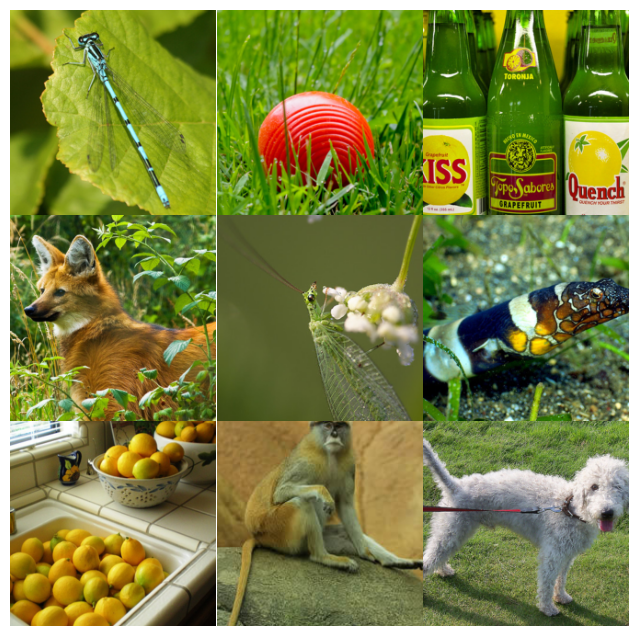

In [203]:
yy = plot_imgs(true_botk)
yy = plot_imgs(true_topk)